In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Импортируем необходимые для работы функции и классы

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from catboost import CatBoostRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Предупреждеия

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Унификация шрифта

In [4]:
matplotlib.rcParams.update({'font.size': 14})

### Функция для подсчета метрик

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Путь к файлам с данными

In [6]:
TRAIN_DATASET_PATH = 'reports/train.csv'
TEST_DATASET_PATH = 'reports/test.csv'

### Загрузка данных

Описание датасета

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

### Считываем обучающий набор данных

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


#### Считываем тестовый набор данных

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


#### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
num_feat = list(train_df.select_dtypes(exclude='object').columns)
obj_feat = list(train_df.select_dtypes(include='object').columns)
target = 'Price'
train_df['Id'] = train_df['Id'].astype(str)

num_feat

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price']

#### Количество строк в тесте и трейне

In [11]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте: 5000


In [12]:
train_df.shape[1] - 1 == test_df.shape[1]

True

In [13]:
submission_df = pd.read_csv('reports/sample_submission.csv')

### Целевая переменная

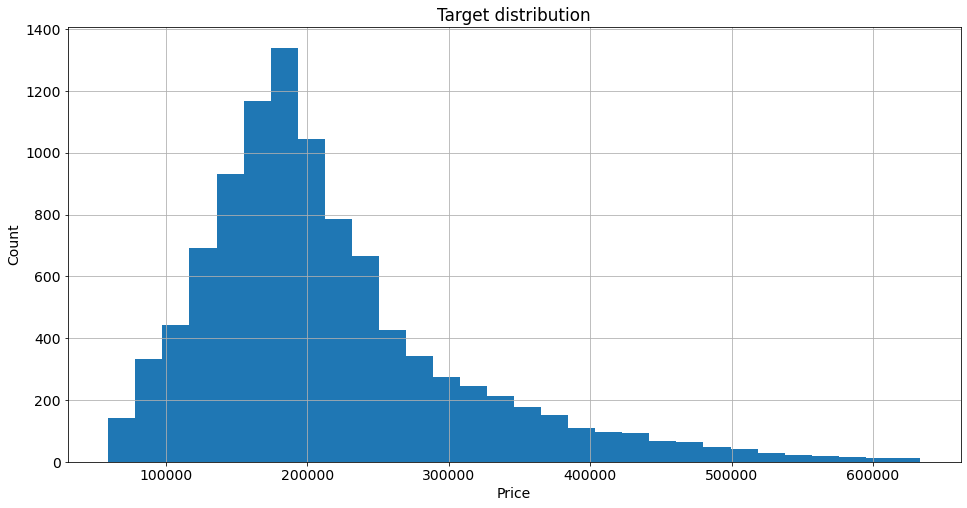

In [14]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные.

In [15]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Номинативные переменные

In [16]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [18]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [19]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

#### Поиск выбросов

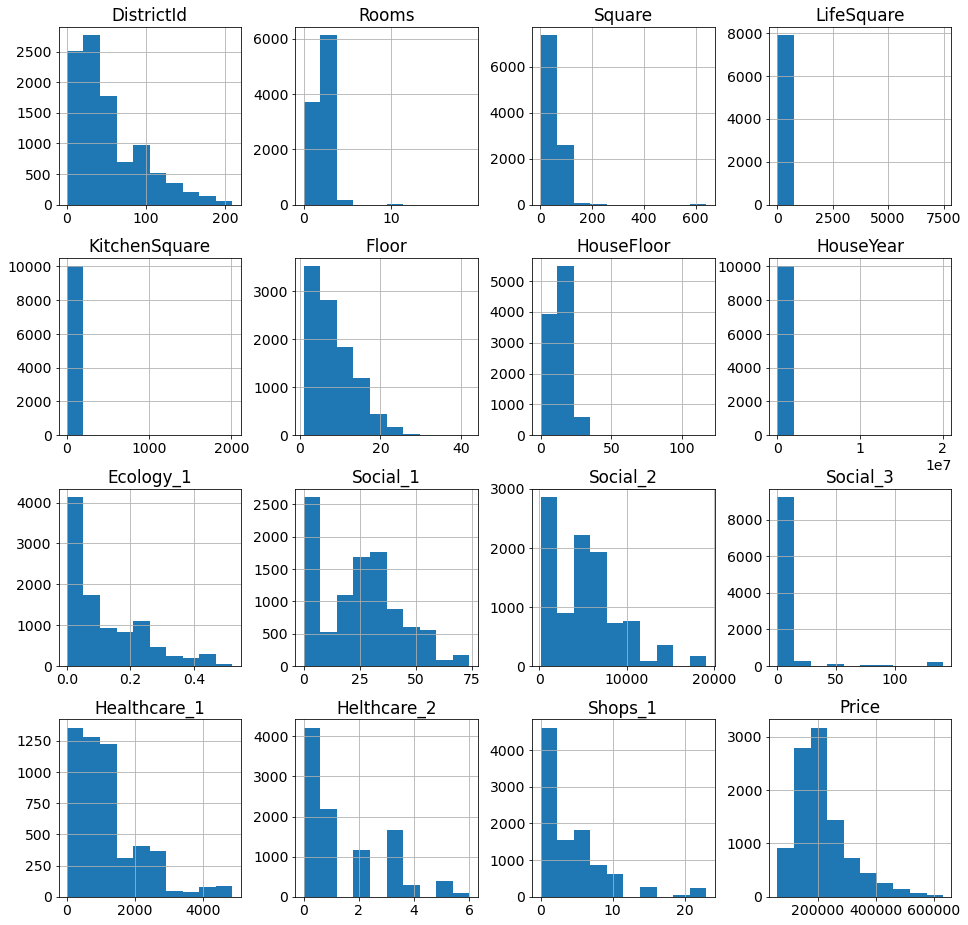

In [21]:
train_df[list(train_df.select_dtypes(exclude='object').columns)].hist(
    figsize=(16,16)
)
plt.show()

In [22]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


#### Выбросы наблюдаются в: HouseYear, KitchenSquare.

#### Признаки с аномально высоким значением, которые нужно будет ограничить: HouseFloor, LifeSquare, Rooms, Square.

#### Square

In [23]:
train_df['Square'].sort_values().round(1)

7470      1.1
4496      2.0
9869      2.4
8572      2.6
161       3.0
        ...  
7644    212.9
1906    275.6
7010    409.4
726     604.7
9229    641.1
Name: Square, Length: 10000, dtype: float64

#### Rooms

In [24]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

#### LifeSquare

In [25]:
train_df['LifeSquare'].sort_values().round(1)

3113    0.4
1829    0.6
119     0.8
9869    0.9
6882    1.0
       ... 
9975    NaN
9978    NaN
9981    NaN
9983    NaN
9991    NaN
Name: LifeSquare, Length: 10000, dtype: float64

#### В 'LifeSquare' Помимо выбросов есть пропуски.

In [26]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

#### HouseFloor

In [27]:
train_df['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
39.0        2
48.0        2
99.0        2
29.0        1
44.0        1
47.0        1
36.0        1
31.0        1
38.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

#### KitchenSquare

In [28]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [29]:
train_df.isna().sum()

Id                   0
DistrictId           0
Rooms                0
Square               0
LifeSquare           0
KitchenSquare        0
Floor                0
HouseFloor           0
HouseYear            0
Ecology_1            0
Ecology_2            0
Ecology_3            0
Social_1             0
Social_2             0
Social_3             0
Healthcare_1      4798
Helthcare_2          0
Shops_1              0
Shops_2              0
Price                0
LifeSquare_nan       0
dtype: int64

#### Обработка оставшихся пропусков

In [30]:
class Data:
    
    def __init__(self):
        """Константы для обработки выбросов на основе анализа данных"""
        self.Square_min = 15
        self.Square_max = 300
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        
        self.Rooms_min = 1
        self.Rooms_max = 5
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.current_year = datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, train_df):
        
        # медианные значения
        self.medians = train_df[['LifeSquare', 'HouseFloor']].median()
        
        # подсчет популярных районов
        self.DistrictId_value_counts = dict(train_df['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        train_df_temp = train_df.loc[((train_df['Square'] > self.Square_min) & (train_df['Square'] < self.Square_max))]
        train_df_temp["SquareMeterPrice"] = train_df_temp["Price"] / train_df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = train_df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del train_df_temp
        
    def transform(self, train_df):
        
        # Обработка пропусков
        train_df['HouseFloor'] = train_df['HouseFloor'].fillna(self.medians)
        
        # Обработка выбросов
        
        # площадь
        train_df.loc[(train_df['Square'] > self.Square_max), 'Square'] = self.Square_max
        train_df.loc[(train_df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        train_df.loc[(train_df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        train_df.loc[(train_df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        train_df.loc[(train_df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        train_df.loc[(train_df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        train_df.loc[(train_df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        train_df.loc[(train_df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        train_df.loc[(train_df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        train_df.loc[(train_df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        train_df.loc[(train_df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # если этаж больше этажности дома, то присваиваем случайный этаж от self.HouseFloor_min до максимального этажа в доме
        floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
        train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
        
        # Обработка категорий
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return train_df
    
    def features(self, train_df):
        
        # добавление признака популярности района
        train_df['DistrictId_counts'] = train_df['DistrictId'].map(self.DistrictId_value_counts)
        train_df['DistrictId_counts'].fillna(train_df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
        train_df = train_df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageSquareMeterPrice'].fillna(train_df['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        train_df = train_df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)
        
        return train_df

#### Инициализация класса Data

In [31]:
data_inst = Data()

# тренировочные данные
data_inst.fit(train_df)
train_df = data_inst.transform(train_df)
train_df = data_inst.features(train_df)

# тестовые данные
test_df = data_inst.transform(test_df)
test_df = data_inst.features(test_df)

#### Отбор признаков

In [32]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquare_nan',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'DistrictId_counts',
 'AverageSquareMeterPrice',
 'AverageHealthcare_1']

In [33]:
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1']
target_name = 'Price'

In [34]:
train_df = train_df[feature_names + [target_name]]
test_df = test_df[feature_names + ['Id']]
X = train_df[feature_names]
y = train_df[target_name]

### Разбиение на train и test

### Обучение модели на CatBoostRegressor

In [35]:
final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

final_model.fit(X, y)

cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

#### Оценка модели

In [36]:
print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.755


#### Сортировка признаков по важности

In [37]:
feature_importances = pd.DataFrame(
    zip(X.columns, final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
3,Square,27.812398
0,AverageSquareMeterPrice,18.523992
8,HouseYear,8.213474
5,KitchenSquare,5.487547
4,LifeSquare,5.356457
7,HouseFloor,4.143636
1,DistrictId_counts,4.099713
6,Floor,4.051739
10,Ecology_1,3.898626
12,Social_2,3.650851


#### Прогнозирование на тестовом датасете

In [38]:
test_df.shape

(5000, 23)

In [39]:
test_df

,AverageSquareMeterPrice,DistrictId_counts,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Helthcare_2,...,Social_3,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,AverageHealthcare_1,Id
0,4572.483767,104.0,1.0,36.847630,19.094182,5.0,5,9.0,1970,1,...,0,1,0,1,0,1,0,1,905.979798,4567
1,2818.749357,247.0,1.0,42.493907,42.568133,10.0,7,17.0,2017,0,...,1,0,0,1,0,1,1,0,2300.000000,5925
2,2766.023246,851.0,2.0,59.463678,NaN,9.0,19,19.0,1977,0,...,0,1,0,1,0,1,0,1,832.258065,960
3,2284.108677,565.0,3.0,49.646030,33.893825,6.0,2,2.0,1965,0,...,0,0,0,1,0,1,0,1,0.000000,3848
4,3355.343060,114.0,1.0,53.837056,NaN,3.0,8,17.0,1977,0,...,4,6,0,1,0,1,0,1,832.258065,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4145.367548,89.0,2.0,43.177521,30.339945,5.0,4,5.0,1962,1,...,4,2,0,1,0,1,0,1,1783.400000,10379
4996,4515.795241,36.0,3.0,93.698122,94.521465,10.0,21,27.0,2018,0,...,2,7,0,1,0,1,0,1,520.000000,16138
4997,4177.749766,97.0,1.0,33.656723,19.003259,5.0,2,5.0,1966,2,...,1,5,0,1,0,1,0,1,1427.113402,3912
4998,4377.498005,56.0,1.0,38.635155,20.976257,9.0,8,14.0,1970,0,...,5,11,0,1,0,1,0,1,832.258065,5722


In [41]:
submit = pd.read_csv('reports/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [42]:
preds_final = pd.DataFrame()
preds_final['Id'] = test_df['Id'].copy()

test_df.set_index('Id', inplace=True)
test_df = test_df[feature_names]

In [43]:
cb_pred_final = final_model.predict(test_df)

submission_df['Price'] = cb_pred_final
submission_df.to_csv('cb_pred_final.csv', index=False, encoding='utf-8', sep=',')

submission_df.head()

,Id,Price
0,4567,166777.904449
1,5925,110605.427051
2,960,141096.123309
3,3848,105167.892631
4,746,172058.301448
